In [1]:
import os
import networkx as nx
import pandas as pd
import graspologic
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from tensorflow.keras import layers, optimizers, losses, metrics, Model, Sequential, utils
from sklearn import preprocessing, model_selection


data_dir = os.path.expanduser("~/Documents/Neural Data Design/cora")

In [2]:
edgelist = pd.read_csv(os.path.join(data_dir, "cora.cites"), sep='\t', header=None, names=["target", "source"])
edgelist["label"] = "cites"

In [3]:
Gnx = nx.from_pandas_edgelist(edgelist, edge_attr="label")
nx.set_node_attributes(Gnx, "paper", "label")

In [4]:
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
node_data = pd.read_csv(os.path.join(data_dir, "cora.content"), sep='\t', header=None, names=column_names)
Y = node_data.to_numpy()[:, 0:1433]
labels = node_data["subject"].to_numpy()

In [5]:
A = graspologic.utils.import_graph(Gnx)

In [6]:
def plot_latents(latent_positions, *, title, labels, ax=None):
    if ax is None:
        ax = plt.gca()
    plot = sns.scatterplot(latent_positions[:, 0], latent_positions[:, 1], hue=labels, 
                           linewidth=0, s=10, ax=ax, palette="Set1")
    plot.set_title(title, wrap=True);
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.legend(bbox_to_anchor=(1.5, 1), loc="upper right", title="Community")
    
    return plot

/Users/ze/opt/miniconda3/envs/Stellar/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


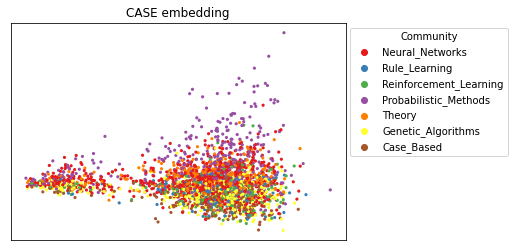

In [7]:
from graspologic.embed import CovariateAssistedEmbed as CASE

case = CASE(alpha=0.5, assortative=False, n_components=16)
latents = case.fit_transform((A, Y))
plot_latents(latents, title=r"CASE embedding", labels=labels);

## Train a classifier on CASE latent positions

In [8]:
node_subjects = pd.Series(labels)
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=0.1, test_size=None, stratify=node_subjects
)

target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
test_targets = target_encoding.transform(test_subjects)


train_data = latents[train_subjects.index.values, :]
test_data = latents[test_subjects.index.values, :]

## Create Keras model

In [9]:
model = Sequential(
    layers.Dense(units=train_targets.shape[1], activation="softmax")
)

In [10]:
model.compile(
    optimizer=optimizers.Adam(lr=0.03),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

## Train the model

In [11]:
model.fit(train_data, train_targets, epochs=100)

Epoch 1/100
9/9 [==============================] - 0s 924us/step - loss: 1.9258 - acc: 0.2016
Epoch 2/100
9/9 [==============================] - 0s 717us/step - loss: 1.8393 - acc: 0.3046
Epoch 3/100
9/9 [==============================] - 0s 602us/step - loss: 1.7835 - acc: 0.3154
Epoch 4/100
9/9 [==============================] - 0s 638us/step - loss: 1.7538 - acc: 0.3164
Epoch 5/100
9/9 [==============================] - 0s 598us/step - loss: 1.7731 - acc: 0.2741
Epoch 6/100
9/9 [==============================] - 0s 619us/step - loss: 1.7296 - acc: 0.2929
Epoch 7/100
9/9 [==============================] - 0s 624us/step - loss: 1.7284 - acc: 0.2559
Epoch 8/100
9/9 [==============================] - 0s 641us/step - loss: 1.6696 - acc: 0.3100
Epoch 9/100
9/9 [==============================] - 0s 652us/step - loss: 1.6343 - acc: 0.3498
Epoch 10/100
9/9 [==============================] - 0s 610us/step - loss: 1.6249 - acc: 0.3406
Epoch 11/100
9/9 [==============================] - 0s 607u

## Evaluate the model

In [12]:
test_loss, test_acc = model.evaluate(test_data,  test_targets, verbose=2)

print('\nTest accuracy:', test_acc)

77/77 - 0s - loss: 1.0600 - acc: 0.6591

Test accuracy: 0.6591468453407288


## Make prediction for all the nodes

In [13]:
all_predictions = model.predict(latents)

In [14]:
node_predictions = target_encoding.inverse_transform(all_predictions)

/Users/ze/opt/miniconda3/envs/Stellar/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


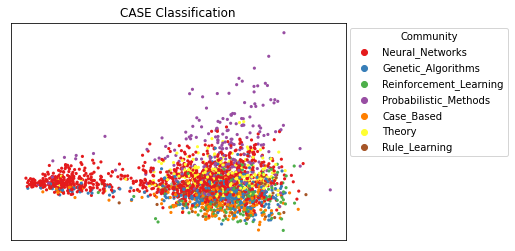

In [15]:
plot_latents(latents, title=r"CASE Classification", labels=node_predictions);

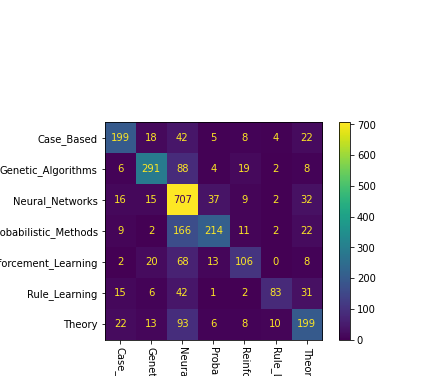

In [16]:
cm = confusion_matrix(labels, node_predictions, labels=['Case_Based', 'Genetic_Algorithms', 'Neural_Networks',
       'Probabilistic_Methods', 'Reinforcement_Learning', 'Rule_Learning',
       'Theory'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Case_Based', 'Genetic_Algorithms', 'Neural_Networks',
       'Probabilistic_Methods', 'Reinforcement_Learning', 'Rule_Learning',
       'Theory'])
disp.plot(xticks_rotation=270)

In [17]:
np.unique(labels)

array(['Case_Based', 'Genetic_Algorithms', 'Neural_Networks',
       'Probabilistic_Methods', 'Reinforcement_Learning', 'Rule_Learning',
       'Theory'], dtype=object)

## Search in alpha and n_components

In [18]:
M = 20
N = 20
a_range = np.geomspace(10e-5, 100, num=M)
components_range = range(2, N+2)
test_loss = np.zeros((M, N))
test_acc = np.zeros((M, N))

for a, i in zip(a_range, range(0, M)):
    for n, j in zip(components_range, range(0, N)):
        case = CASE(alpha=a, assortative=True, n_components=n)
        latents = case.fit_transform((A, Y))
        train_data = latents[train_subjects.index.values, :]
        test_data = latents[test_subjects.index.values, :]
        model = Sequential(
            layers.Dense(units=train_targets.shape[1], activation="softmax")
        )
        model.compile(
            optimizer=optimizers.Adam(lr=0.03),
            loss=losses.categorical_crossentropy,
            metrics=["acc"],
        )
        model.fit(train_data, train_targets, epochs=50, verbose=0)
        test_loss[i, j], test_acc[i, j] = model.evaluate(test_data,  test_targets, verbose=0)

In [22]:
a_range = np.geomspace(10e-5, 100, num=M)
components_range = range(2, N+2)
a_range, components_range = np.meshgrid(a_range, components_range)

Text(0.5, 0, 'accuracy')

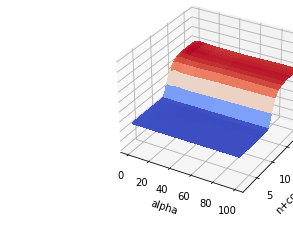

In [24]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(a_range, components_range, test_acc, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0, 1)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('alpha')
ax.set_ylabel('n_components')
ax.set_zlabel('accuracy');